
# Sneaker Finder development notebook

### version 0.1 Jan 2020
### version 0.2 Feb 2020
### version 0.3 June 2020

# OVERVIEW

This is a project initiated while an Insight Data Science fellow.  It grew out of my interest in making data driven tools in the fashion/retail space I had most recently been working.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some initial sneakers based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.


# Part 0: DATA

01_data.ipynb

# Part 1: MobileNet_v2 as feature extractor (+ resnet50 for comparison)
embed database into feature space.

evaluate by simple logistic regression on classification.

# Part 2: tune conv-net feature extractor to my space (MobileNet_V2 + ResNet)

In [ ]:
#hide
from fastbook import *
from fastai.vision.all import *
import torchvision

config = Config()

In [ ]:
#from sklearn.neighbors import NearestNeighbors

In [ ]:
# load our core data
filename = "zappos-50k-simplified_sort" # no features


df = pd.read_pickle(f"data/{filename}.pkl")

#DATA_path = Path.home()/'Projects/DATABASE'
path_images = Path(config.d['data_path']+'/ut-zap50k-images')


# Lets test a few different sizes

IMG_SIZE_LG = 224
IMG_SIZE_MD = 160
IMG_SIZE_SM = 128
IMG_SIZE = IMG_SIZE_MD

IMG_SIZES = {"small":  IMG_SIZE_SM,
             "medium": IMG_SIZE_MD,
             "large":  IMG_SIZE_LG}

In [ ]:
df.head()

,CID,Category,path,path_and_file,Category1,Category2,Filename,Sneakers,Boots,Shoes,Slippers,Adult,Gender,train,test,validate,t_t_v
0,7965307-5291,Boots,Boots/Ankle/A. Testoni/7965307.5291.jpg,"[Boots, Ankle, A. Testoni, 7965307.5291.jpg]",Boots,Ankle,7965307.5291.jpg,False,True,False,False,True,Men,True,False,False,train
1,7999255-363731,Boots,Boots/Ankle/A. Testoni/7999255.363731.jpg,"[Boots, Ankle, A. Testoni, 7999255.363731.jpg]",Boots,Ankle,7999255.363731.jpg,False,True,False,False,True,Men,True,False,False,train
2,8000978-364150,Boots,Boots/Ankle/A. Testoni/8000978.364150.jpg,"[Boots, Ankle, A. Testoni, 8000978.364150.jpg]",Boots,Ankle,8000978.364150.jpg,False,True,False,False,True,Men,False,True,False,test
3,8113228-1897,Boots,Boots/Ankle/AIGLE/8113228.1897.jpg,"[Boots, Ankle, AIGLE, 8113228.1897.jpg]",Boots,Ankle,8113228.1897.jpg,False,True,False,False,True,Women,True,False,False,train
4,8113228-1912,Boots,Boots/Ankle/AIGLE/8113228.1912.jpg,"[Boots, Ankle, AIGLE, 8113228.1912.jpg]",Boots,Ankle,8113228.1912.jpg,False,True,False,False,True,Women,True,False,False,train


In [ ]:
doc(Normalize)

In [ ]:
# this is the headless feature extractor that made embedding from 02_features

def get_mnetV2_feature_net(to_cuda=False):
    ## use an "identity" layer to replace 1000 category classifier
    class Identity(nn.Module):
        def __init__(self):
            super(Identity, self).__init__()

        def forward(self, x):
            return x
    mnetv2  = torchvision.models.mobilenet_v2(pretrained=True)
    mnetv2.classifier = Identity()
    if to_cuda:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")
    mnetv2 = mnetv2.to(device)
    mnetv2.eval()

    # just incase we forget the no_grad()
    for param in mnetv2.parameters():
        param.requires_grad = False
        
    return mnetv2

In [ ]:
def get_ResNet_feature_net(to_cuda=False):
    
    ## use an "identity" layer to replace 1000 category classifier
    class Identity(nn.Module):
        def __init__(self):
            super(Identity, self).__init__()

        def forward(self, x):
            return x
    
    resnet  = torchvision.models.resnet50(pretrained=True) 
    num_ftrs = resnet.fc.in_features
    print(num_ftrs)
    
    resnet.fc = Identity()
    
    if to_cuda:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")
    resnet = resnet.to(device)
    resnet.eval()

    # just incase we forget the no_grad()
    for param in resnet.parameters():
        param.requires_grad = False
        
    return resnet



rnet = get_ResNet_feature_net(to_cuda=True)

2048


# Part 3: full transfer learning.  re-tune MobileNet_v2 (and ResNet) to classify my data

We have started to validate the approach that embedding sneaker images into a conv net space can help us find "aesthetically similar" sneakers.  Specifically, we have seen clear grouping in UMAP visualization and pretty good accuracy for categorization by simple regression on the "features".  

Now lets see if we can tune the network to do even better.  Lets fine-tune our network so it performs even better at categorizing the shoe categories.


In [ ]:
# some helper functions.
def get_x(r): return path_images/r['path']
def get_y(r): return r['Category']
def splitter(df):
    train = df.index[df['train']].tolist()
    valid = df.index[df['validate']].tolist()
    return train,valid


batch_tfms = Normalize.from_stats(*imagenet_stats)
rand_tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=5.0, 
               min_zoom=1.0, 
               max_zoom=1.05, 
               max_lighting=0.1, 
               max_warp=0.05, 
               p_affine=0.75, 
               p_lighting=0.0, 
               xtra_tfms=None, 
               size=None, 
               mode='bilinear', 
               pad_mode='reflection', 
               align_corners=True, 
               batch=False, 
               min_scale=1.0)

In [ ]:
# put everythign in train, and don't do any augmentation since we are just going 
# resize to 160
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=splitter, 
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(IMG_SIZE,method='pad', pad_mode='border'),
                   batch_tfms=rand_tfms)  # border pads white...


# # set up the helper functions to pass data into the
# def get_x(r): return path_images/r['path']
# #def get_y(r): return r['Category']  # we aren't actually using the category here (see 02_model.ipynb)
# def get_fname(r): return r['path']

# # put everythign in train, and don't do any augmentation since we are just going 
# # resize to 224
# dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
#                    splitter=IndexSplitter([]),
#                    get_x=get_x, 
#                    get_y=get_fname,
#                    item_tfms=Resize(IMG_SIZE, method='pad', pad_mode='border'),
#                    batch_tfms=Normalize.from_stats(*imagenet_stats))  # border pads white...


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dls = dblock.dataloaders(df,bs=64,drop_last=False,device=device)

In [ ]:
# copied the split and cut from denseness ... need to check if the splits and cut make sense
def _mobilenet_v2_split(m:torch.nn.Module): return L(m[0][0][:7],m[0][0][7:], m[1:]).map(params)
_mobilenet_v2_meta   = {'cut':-1, 'split':_mobilenet_v2_split, 'stats':imagenet_stats}
model_meta[torchvision.models.mobilenet_v2] = {**_mobilenet_v2_meta}

In [ ]:
# create dls 
learn = cnn_learner(dls, 
                    torchvision.models.mobilenet_v2, 
                    #splitter=mobilenet_split,cut=-1, 
                    pretrained=True,metrics=error_rate)

(0.014454397559165954, 0.001737800776027143)

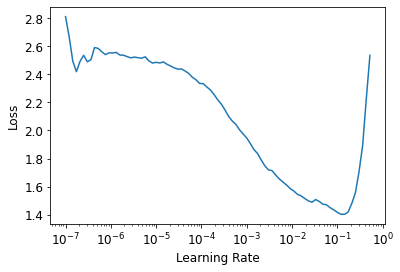

In [ ]:
lr_min, lr_steep = learn.lr_find()

lr_min,lr_steep

In [ ]:
learn.fine_tune(2, base_lr=lr_steep)
# 1 epoch "learn.freeze()" or classifier ("head")only
#2 epochs  "unfreeze()"

epoch,train_loss,valid_loss,error_rate,time
0,0.380474,0.279281,0.092496,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.230578,0.183041,0.061597,00:51
1,0.162563,0.152405,0.054775,00:51


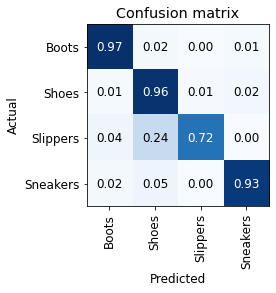

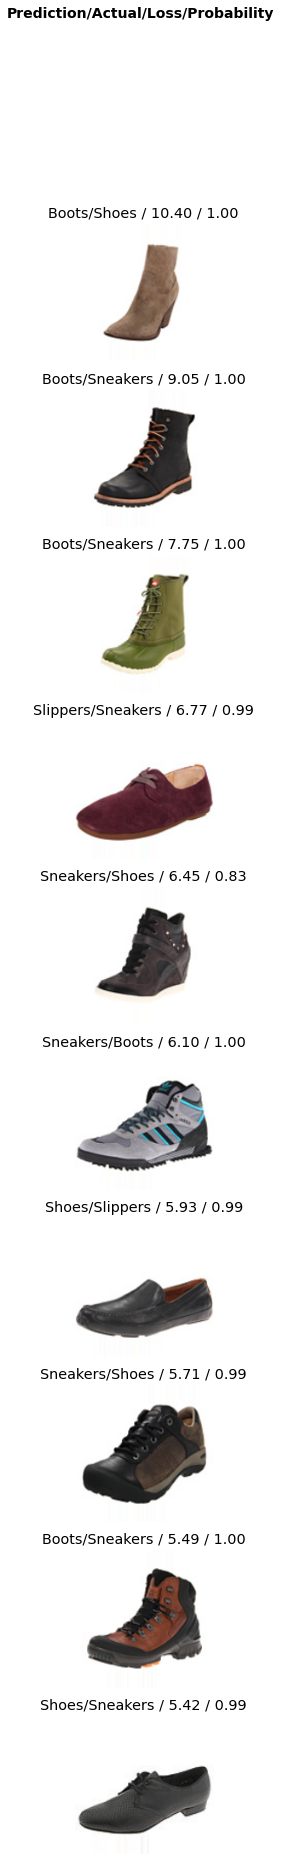

In [ ]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)

interp.plot_top_losses(10, nrows=10)

learn.export(fname="data/export_mnet_finetune0")


In [ ]:
??learn.fine_tune

In [ ]:
head_lr = lr_steep
# reinstantiate learner
learn = cnn_learner(dls, 
                    torchvision.models.mobilenet_v2, 
                    #splitter=mobilenet_split,cut=-1, 
                    pretrained=True,metrics=error_rate)
# 10 epochs of fitting the classifier at the "optimal" lr
n_epoch = 10
learn.fit_one_cycle(n_epoch, head_lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.416869,0.293445,0.082464,00:41
1,0.257348,0.195755,0.067817,00:40
2,0.221598,0.180001,0.062600,00:41
3,0.190417,0.210697,0.071027,00:41
4,0.161858,0.166044,0.059390,00:41
5,0.147427,0.142430,0.050762,00:41
6,0.147590,0.134110,0.050963,00:40
7,0.113033,0.130761,0.047953,00:40
8,0.102361,0.133184,0.046549,00:42
9,0.101589,0.131180,0.049157,00:41


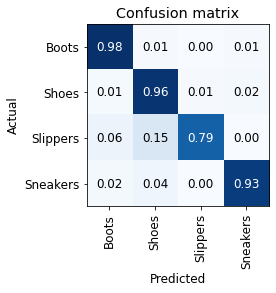

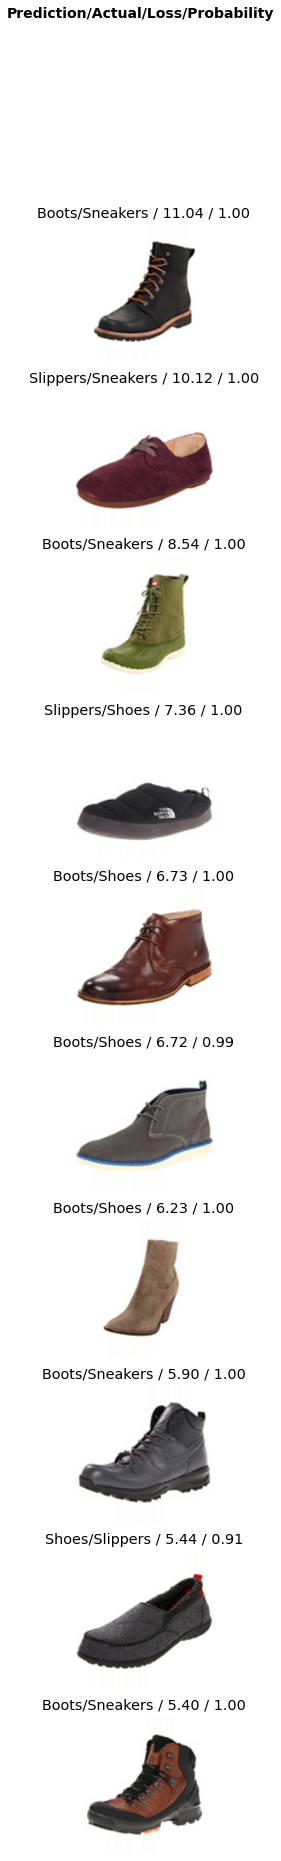

In [ ]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)

interp.plot_top_losses(10, nrows=10)

learn.export(fname="data/export_mnet_headOnly")


In [ ]:
# create dls 
learn_r = cnn_learner(dls, 
                    torchvision.models.resnet50, 
                    #splitter=mobilenet_split,cut=-1, 
                    pretrained=True,metrics=error_rate)

(0.017378008365631102, 0.0002754228771664202)

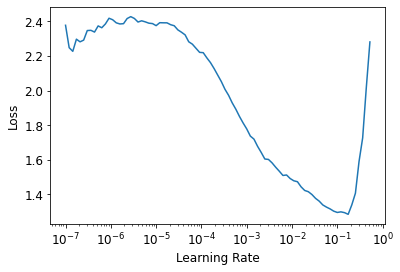

In [ ]:
lr_min, lr_steep = learn_r.lr_find()
lr_min,lr_steep

In [ ]:
lr_min,lr_steep

(0.017378008365631102, 0.0002754228771664202)

In [ ]:
base_lr = lr_steep
learn_r.fine_tune(2, base_lr=base_lr)
# 1 epoch "learn.freeze()" or classifier ("head")only
#2 epochs  "unfreeze()"

epoch,train_loss,valid_loss,error_rate,time
0,0.528153,0.318328,0.097311,01:36


epoch,train_loss,valid_loss,error_rate,time
0,0.315240,0.225185,0.073034,02:12
1,0.215056,0.196286,0.065008,02:12


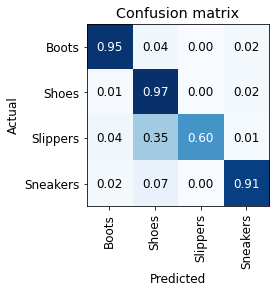

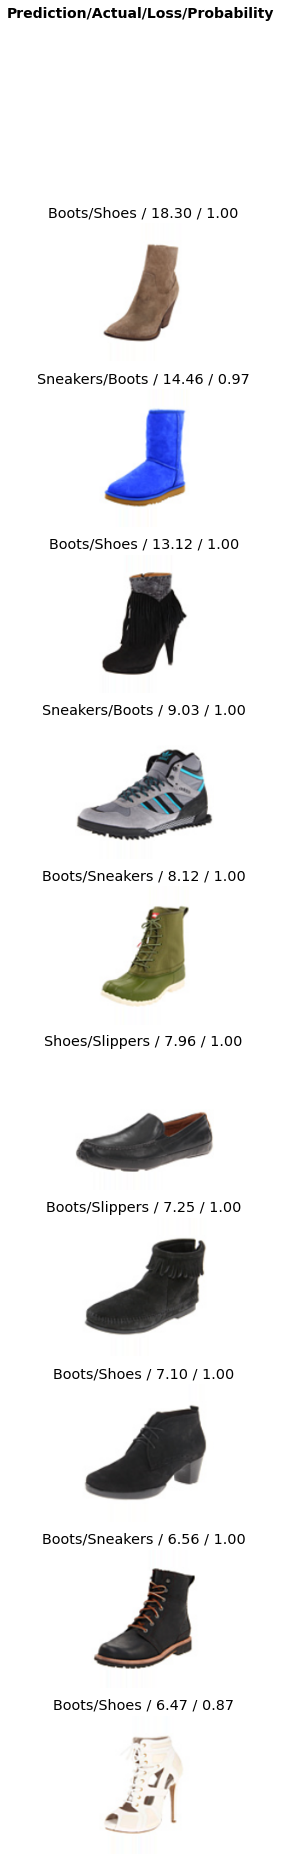

In [ ]:

interp = ClassificationInterpretation.from_learner(learn_r)
interp.plot_confusion_matrix(normalize=True)

interp.plot_top_losses(10, nrows=10)

learn_r.export(fname="data/export_rnet_finetune0")


In [ ]:
head_lr = lr_steep
# reinstantiate learner


In [ ]:
del learn
learn = cnn_learner(dls, 
                    torchvision.models.resnet50, 
                    #splitter=mobilenet_split,cut=-1, 
                    pretrained=True,metrics=error_rate)
# 10 epochs of fitting the classifier at the "optimal" lr
n_epoch = 10
learn.fit_one_cycle(n_epoch, head_lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.558218,0.341988,0.101324,01:35
1,0.368903,0.264644,0.083868,01:36
2,0.266035,0.220505,0.076445,01:36
3,0.215335,0.181149,0.066613,01:36
4,0.205569,0.174809,0.064607,01:36
5,0.169407,0.161398,0.057584,01:36
6,0.145496,0.155163,0.054173,01:36
7,0.134539,0.155047,0.054173,01:36
8,0.139493,0.152410,0.054173,01:36
9,0.125170,0.155008,0.054374,01:36


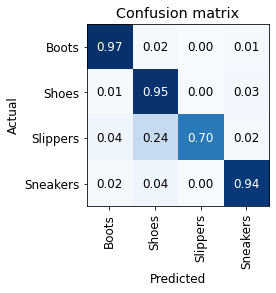

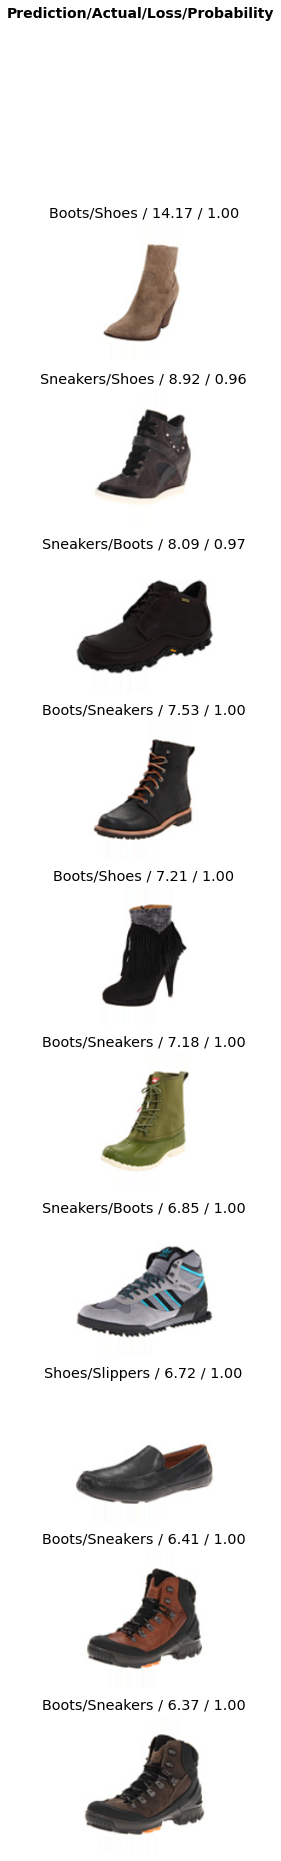

In [ ]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)

interp.plot_top_losses(10, nrows=10)

learn.export(fname="data/export_resnet_headOnly")


(6.309573450380412e-08, 7.585775847473997e-07)

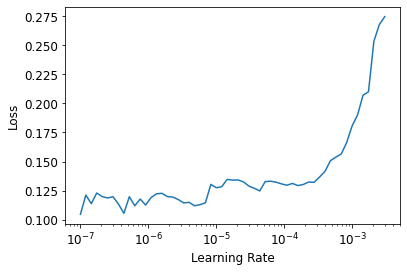

In [ ]:
# unfreeze
learn.unfreeze()
#learn.freeze_to(n)

# find a new optimal lr for the 
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [ ]:


# set a discriminatev learning rate 
lr_max=slice(1e-7,1e-5)
learn.fit_one_cycle(6, lr_max=lr_max)

epoch,train_loss,valid_loss,error_rate,time
0,0.119468,0.154233,0.054976,02:11
1,0.123517,0.156093,0.054575,02:11
2,0.127156,0.152067,0.054173,02:12
3,0.112746,0.150239,0.052568,02:12
4,0.105994,0.152291,0.052568,02:12
5,0.106595,0.152287,0.053571,02:12


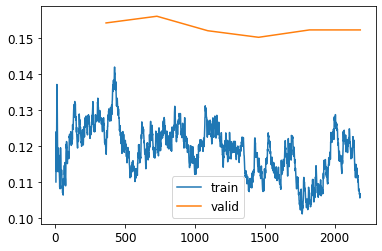

In [ ]:
#learn.fit_one_cycle(6, lr_max=1e-5)

learn.recorder.plot_loss()

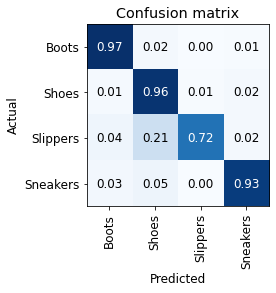

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)

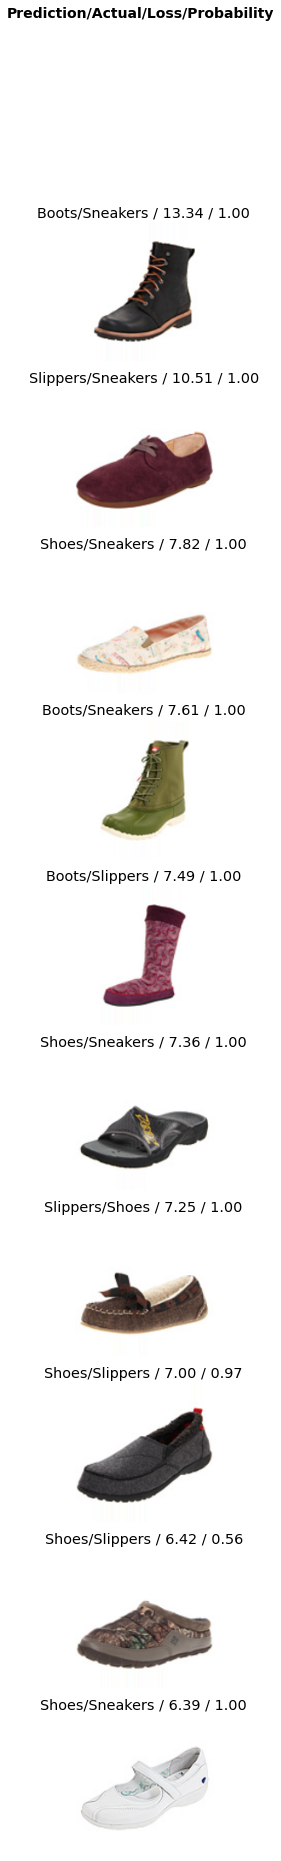

In [ ]:
interp.plot_top_losses(10, nrows=10)

In [ ]:
learn.export(fname="data/export_uncleaned")

In [ ]:
learn.opt.state_dict()

{'state': [{},
  {'force_train': True,
   'do_wd': False,
   'grad_avg': tensor([ 4.2039e-45, -6.3355e-03,  9.0763e-03,  3.0862e-03, -2.3200e-03, -5.5748e-03, -3.4187e-03, -5.5197e-03, -9.5777e-03,  0.0000e+00,  1.4423e-03, -6.7739e-03,  1.9001e-03,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  4.0195e-03, -4.0222e-04,  1.1288e-03,  1.2996e-03, -1.8792e-03,  0.0000e+00,  8.7576e-04, -3.7388e-03, -4.3892e-06, -1.4171e-03,
           -8.6373e-04,  1.2486e-04,  1.3374e-03, -5.6933e-04], device='cuda:0'),
   'sqr_avg': tensor([6.0888e-30, 1.0845e-03, 1.0808e-03, 1.8986e-04, 3.1613e-03, 3.1430e-04, 5.1716e-04, 6.6688e-04, 1.8909e-03, 0.0000e+00, 1.0150e-04, 2.2000e-03, 1.8873e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 5.4547e-04, 3.0937e-05, 8.0507e-05, 5.3273e-04, 1.8405e-04, 0.0000e+00, 1.4270e-04, 1.0231e-03, 6.7266e-03, 6.9365e-04, 6.7164e-06, 2.0625e-07, 5.8042e-05, 3.9021e-04],
          device='cuda:0'),
   'step': 5824}

In [ ]:
# Specify a path
PATH = "state_dict_model.pt"

# Save
torch.save(net.state_dict(), PATH)

# Load
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
from fastai.vision.widgets import *

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: [Errno 2] No such file or directory: 'Shoes'

In [ ]:
??ImagesCleaner


In [ ]:
doc(ImageClassifierCleaner)

In [ ]:
#hide_output
cleaner = MYImageClassifierCleaner(learn)
cleaner

FileNotFoundError: [Errno 2] No such file or directory: 'Shoes'

In [ ]:

widgets.FileUpload(
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)


carosel

color_picker = widgets.ColorPicker(
    concise=True,
    description='Background color:',
    value='#efefef',
)
color_picker

widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)


items = [widgets.Label(str(i)) for i in range(8)]
widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(3, 100px)"))

items = [widgets.Label(str(i)) for i in range(4)]
widgets.HBox(items)

In [ ]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
model_conv = torchvision.models.mobilenet_v2(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# just read this off: model_conv.classifier
num_categories = 4

num_ftrs = model_conv.classifier._modules['1'].in_features
model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, num_categories)

def trns_mobilenet_v2():
    model_conv = torchvision.models.mobilenet_v2(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    # just read this off: model_conv.classifier
    num_ftrs = model_conv.classifier._modules['1'].in_features
    model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, num_categories)
    
    return model_conv



mnetV2 = torchvision.models.mobilenet_v2()

In [ ]:
import torchvision
from torchvision import models

# def _mobilenetv2_split(m:nn.Module): 
#     return (m[0][0][10],m[1])(m:nn.Module): return (m[0][0][10],m[1])

mobilenet_split = lambda m: (m[0][0][10], m[1])
#arch  = torchvision.models.mobilenet_v2

model_conv  = models.mobilenet_v2(pretrained=True)

#learn = cnn_learner(dls, models.mobilenet_v2, cut=-1, pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)



# OLD RANDOM STUFF

In [ ]:
database_json = json.load(open(f"{filename}.json"))
df = pd.DataFrame(database_json)

In [ ]:
m = nn.Sequential(nn.AdaptiveAvgPool2d(5), nn.Linear(2,3), nn.Conv2d(2,3,1), nn.MaxPool3d(5))
assert has_pool_type(m)

test_eq([has_pool_type(m_) for m_ in m.children()], [True,False,False,True])


tst = lambda pretrained : nn.Sequential(nn.Conv2d(3,5,3), nn.BatchNorm2d(5), nn.AvgPool2d(1), nn.Linear(3,4))
m = create_body(tst)
test_eq(len(m), 2)

m = create_body(tst, cut=3)
test_eq(len(m), 3)

m = create_body(tst, cut=noop)
test_eq(len(m), 4)

for n in range(1,5):    
    m = create_body(tst, n_in=n)
    test_eq(_get_first_layer(m)[0].in_channels, n)

    
tst = create_cnn_model(models.resnet18, 10, True)
tst = create_cnn_model(models.resnet18, 10, True, n_in=1)
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
                )

dls = pets.dataloaders(untar_data(URLs.PETS)/"images", item_tfms=RandomResizedCrop(300, min_scale=0.5), bs=64,
                        batch_tfms=[*aug_transforms(size=224)])


In [ ]:
import torchvision
from torchvision import models

# def _mobilenetv2_split(m:nn.Module): 
#     return (m[0][0][10],m[1])(m:nn.Module): return (m[0][0][10],m[1])

#mobilenet_split = lambda m: (m[0][0][10], m[1])
#arch  = torchvision.models.mobilenet_v2

model_conv  = models.mobilenet_v2(pretrained=True)

#learn = cnn_learner(dls, models.mobilenet_v2, cut=-1, pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model_conv = model_conv.to(device)

In [ ]:
model_conv.feat


NameError: name 'model_conv' is not defined

In [ ]:
files = df.path
full_file_path = [(path_images/file) for file in files]
img_size = 192
df_out = process_image_files(df.index,df.CID,full_file_path, model_conv,img_size)

100%|██████████| 33229/33229 [15:29<00:00, 35.76it/s]


In [ ]:
x = df_out['image_features'].values
x[0][0][:10]

NameError: name 'df_out' is not defined

In [ ]:
# save it

df = pd.merge(df, df_out,  how='left', on='CID')# left_on=['CID'], right_on = ['CID'])


In [ ]:
filename = f"zappos-50k-{model_conv.__class__.__name__}-features"
#df.to_csv(f"{filename}.csv")
df.to_pickle(f"{filename}.pkl")

# 

In [ ]:
df = pd.read_pickle(f"{filename}.pkl")

In [ ]:
df.to_json(f"{filename}.json")

# Part 4: Sneaker Finder 2.0

# Part 5:  caveats + whats next

# pytorch ß-VAE  

This is a cool reference for a fastai VAE
https://medium.com/@dhuynh95/an-introduction-to-unsupervised-learning-with-fastai-a6dbd78eca2b

In [ ]:
x,y = dls.valid.one_batch()

num_categories = len(dls.vocab)

x.shape,y, num_categories


((64, 3, 192, 192),
 TensorCategory([1, 3, 3, 3, 1, 0, 3, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 3, 1, 1, 3, 0,
         0, 3, 1, 3, 0, 3, 1, 1, 3, 0, 0, 1, 3, 1, 0, 0, 3, 1, 3, 1, 3, 0, 0, 1,
         3, 3, 1, 3, 0, 1, 1, 0, 1, 1, 3, 0, 3, 1, 3, 1], device='cuda:0'),
 4)

In [ ]:
#learn = cnn_learner(dls, arch, cut=-1, splitter=mobilenet_split,metrics=error_rate)

#learn = cnn_learner(dls, models.mobilenet_v2, cut=-1, pretrained=True)


# convert each image into a rank 1000 vector...
x_hat = model_conv(x)

# lr_min,lr_steep = learn.lr_find()
# lr_min, lr_steep

In [ ]:
x_hat.shape

torch.Size([64, 1000])

In [ ]:
outputs = arch(x)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.


Replace the classifier module output with something that predicts 'num_categories'.   The `mobilenet_v2` uses a classifier rather than "fc"(fully connected) final module...

In [ ]:
model_conv = torchvision.models.mobilenet_v2(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# just read this off: model_conv.classifier
num_ftrs = model_conv.classifier._modules['1'].in_features
model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, num_categories)

def trns_mobilenet_v2():
    model_conv = torchvision.models.mobilenet_v2(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    # just read this off: model_conv.classifier
    num_ftrs = model_conv.classifier._modules['1'].in_features
    model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, num_categories)
    
    return model_conv

In [ ]:
mobilenet_split = lambda m: (m[0][0][10], m[1])

learn = cnn_learner(dls, models.mobilenet_v2, splitter=mobilenet_split,cut=-1, pretrained=True)

(1.318256749982538e-07, 1.0964781722577754e-06)

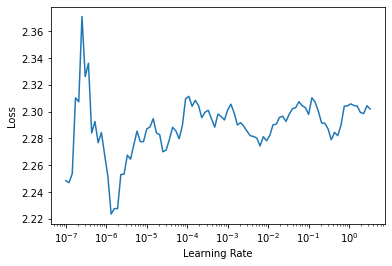

In [ ]:
lr_min,lr_steep = learn.lr_find()
lr_min, lr_steep

In [ ]:
# get our GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Get the features from MobileNetV2

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                             exp_lr_scheduler, num_epochs=25)

NameError: name 'train_model' is not defined

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = ''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
arch  = torchvision.models.mobilenet_v2(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


In [ ]:
print(os.getcwd())

/Users/ergonyc/Projects/Insight/UTzappos50k


In [ ]:
df.head()


,CID,Category,CategoryDir,SubCategory,path,Category.Shoes,Category.Boots,Category.Sandals,Category.Slippers,SubCategory.Sneakers.and.Athletic.Shoes,...,Unisex,Kids,Mens,Womens,Feminine,Masculine,train,test,validate,validation
9743,7691292-254560,Boots,Boots,Mid-Calf,Boots/Mid-Calf/Lucchese/7691292.254560.jpg,0,1,0,0,0,...,False,False,False,True,True,False,1,0,0,NaN
9744,7691628-275,Slippers,Slippers,Slipper Flats,Slippers/Slipper Flats/Giesswein/7691628.275.jpg,0,0,0,1,0,...,False,False,False,True,True,False,1,0,0,NaN
9745,7691628-253595,Slippers,Slippers,Slipper Flats,Slippers/Slipper Flats/Giesswein/7691628.25359...,0,0,0,1,0,...,False,False,False,True,True,False,1,0,0,NaN
9746,7691974-300221,Boots,Boots,Ankle,Boots/Ankle/GoLite/7691974.300221.jpg,0,1,0,0,0,...,False,False,True,False,False,True,1,0,0,NaN
9747,7692676-3,Boots,Boots,Mid-Calf,Boots/Mid-Calf/Sporto/7692676.3.jpg,0,1,0,0,0,...,False,False,False,True,True,False,1,0,0,NaN


In [ ]:
import matplotlib.pyplot as plt
#import seaborn as sns

import os
from glob import glob

from datetime import datetime

import time
import numpy as np
import pandas as pd


from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#plt.ion()   # interactive mode

from fastai.vision.all import *
import PIL
from PIL import Image

In [ ]:
#######Begin trying to come up with model to tag posts in database#######
from os import listdir
from os.path import isfile, join
from sklearn.decomposition import PCA


def process_image_files(path, label, model): 
    """ Extract image features from image files stored in path
    
    Args: 
        path (str): path to image location 
        label (int): image classification label -- we'll just use 
        model (obj): Keras model for feature extraction 
        
    Return: 
        df (dataframe): pandas dataframe containing filepath, filename labels and image fx
    """
    
    img_height = 224
    img_width = 224
    
    #get all file names in directory, get full file path and assign lables 
    file_names = [f for f in listdir(path) if (isfile(join(path, f)) and f !='.DS_Store')]
    full_file_path = [(path + file) for file in file_names]
    labels = np.ones(len(file_names), dtype = int)*label
    
    #instanstiate ImageFeatures object and save to array 
    image_obj = []
    for file in tqdm_notebook(full_file_path): 
        image_obj.append(ImageFeatures(file, img_height, img_width, model))
    
    #extract image features 
    image_features = []
    for obj in image_obj: 
        image_features.append(obj.img_features)
        
    
    #store all relevant info in a pandas datafram 
    df = pd.DataFrame()
    df['labels'] = labels 
    df['image_features'] = image_features
    df['image_file_path'] = full_file_path
    df['file_names'] = file_names
    
    return(df)
        

# eventually move this into a module
class ImageFeatures: 
    """Process image files and extract features
    Attributes: 
        model (obj): model used to extract features
        image_vector (array): flattened and normalized array of image RGB codes
        img_feature (array): Pooling layer of model 
        
    
    """
    def __init__(self, img_path, pic_width, pic_height, model):
        self.model = model
        img_vec = self.image_process(img_path, pic_width, pic_height)
        self.feature_extraction(img_vec, model)
            
    def image_process(self, img_path, pic_width, pic_height):
        """Get flattened RGB image vector"""
        img_data = image.load_img(img_path, target_size=(pic_width, pic_height))
        image_vector = image.img_to_array(img_data)
        return(image_vector)

    def feature_extraction(self, img_vector, model):
        """Extract image feature vector"""
        img_d = img_vector.copy() #Absolutely essential, otherwise preprocess call will overwrite img_vector
        img_d = np.expand_dims(img_d, axis=0)
        img_d = preprocess_input(img_d) #Problem here, must be convention of keras to pass by reference?
        img_d = imagenet_utils.preprocess_input(img_d)
        self.img_features = model.predict(img_d)

        

In [ ]:
from tqdm import tqdm_notebook        
        
def add_features_to_database(json_filepath, image_filepath, cnn_model): 
    ''' function to take in web-scraped data from etsy and artsy 
    and returns a uniform pandas dataframe with relevant features
    
    updated database saved to json_filepath directory
    
    Args: 
    image_filepath (str): path to folder containing images
    
    Returns: 
    new_df (df): updated pandas dataframe containing image_features, image_quality_score
    
    '''
    #initialize image size
    
    pwidth = 224
    pheight = 224 #
    
    #Load in data  (pass names to json DBs around rather than DataFrames)
    json_file = json.load(open(json_filepath))
    image_df = pd.DataFrame(json_file)

    
    #Convert images to RGB arrays and extract features
    img_objects = []
    for rel_path in tqdm_notebook(image_df['path']):
        print(rel_path)
        print(type(rel_path))
        img_path = image_filepath + rel_path #[0]['path']
        img_obj = ImageFeatures(img_path, pwidth, pheight, cnn_model)
        img_objects.append(img_obj)
        
    #loop over img_objects to get array of features and predict quality scores
    cnn_features = []
    #quality_labels = []
    for entry in img_objects: 
        cnn_features.append(entry.img_features[0,:])
        #quality_labels.append(quality_model.predict(entry.img_features)[0])
    
    #Create new dataframe with relevant features
    new_df = pd.DataFrame()
    #new_df['image_url'] = image_df['image_urls']
    new_df['image_features'] = cnn_features
    #new_df['image_quality_score'] = quality_labels
    #new_df['price'] = [get_price(price) for price in image_df['price']]
    #new_df['vendor'] = [vendor] * len(quality_labels)
           
    save_filepath = json_filepath.split('.json')[0] + '_processed.json'
    new_df.to_json(save_filepath, orient = 'records')
    
    return(new_df)

In [ ]:
#os.chdir('sneaks')
image_df = df


pwidth = 224
pheight = 224 #
json_filepath = summary_file
#Load in data  (pass names to json DBs around rather than DataFrames)
json_file = json.load(open(json_filepath))
image_df = pd.DataFrame(json_file)


#DATAPATH = "/Users/ergonyc/Projects/DATABASE/"


# #from utils import train_val_generator
data_path = = os.path.join(DATAPATH,'xdata/') # path of the data
train_path = './train'
test_path = './test'

TARGET_SZ = 224

input_shape = (TARGET_SZ,TARGET_SZ,3) #(img_width,i mg_height,img_channel)')
#batch_size = 32

cnn_model = MobileNetV2(weights = 'imagenet', 
                            include_top = False, 
                            input_shape = input_shape, 
                            pooling = 'avg')

model_name = 'MobileNetV2'
# with graph.as_default():
#     img_features = network_model.predict(img_vector)



#Loop over paths to get updated database
imagepath = './data/'
df_features = add_features_to_database(summary_file, imagepath, cnn_model)

SyntaxError: invalid syntax (<ipython-input-15-b8cc69b696b7>, line 17)

# load the UT (matlab) data


In [ ]:
# load data from json file...
current_data = "summary_Jun-28-2020"
summary_file = f"{current_data}.json"

json_file = json.load(open(os.path.join(DATAPATH,summary_file)))
df = pd.DataFrame(json_file)
     
    
current_data = "train_test_val_Jun-28-2020"
tt_summary_file = f"{current_data}.json"    
# save the simple file
json_file = json.load(open(os.path.join(DATAPATH,tt_summary_file)))
df = pd.DataFrame(json_file)







In [ ]:
os.chdir('..')

In [ ]:
#Convert images to RGB arrays and extract features
img_objects = []
for rel_path in tqdm_notebook(image_df['path']):
    print(rel_path)
    print(type(rel_path))
    img_path = image_filepath + rel_path #[0]['path']
    img_obj = ImageFeatures(img_path, pwidth, pheight, cnn_model)
    img_objects.append(img_obj)

Shoes/Oxfords/Bostonian/100627.72.jpg
<class 'str'>



NameError: name 'image_filepath' is not defined

# Do Train Test Splits


In [ ]:
import os
from glob import iglob
from os.path import join,basename
import shutil
import random

# UPDATE - JAH, put all data into DATABASE 

data_path = './sneaks/data/' # path of the data
train_path = './train'
test_path = './test'
ldata_path = './data'
val_path = './validate'

df.loc[:,'train'] = 1
df.loc[:,'test'] = 0 
df.loc[:,'validate'] = 0 


In [ ]:
## cat = df['path_and_file']

df.path_and_file.head(5)

0     [Shoes, Oxfords, Bostonian, 100627.72.jpg]
1    [Shoes, Oxfords, Bostonian, 100627.255.jpg]
2     [Shoes, Oxfords, Bostonian, 100657.72.jpg]
3    [Shoes, Oxfords, Bostonian, 100657.216.jpg]
4       [Boots, Mid-Calf, Durango, 101026.3.jpg]
Name: path_and_file, dtype: object

In [ ]:
#for file in iglob(join(data_path,'*')):
#for file( in iglob(join(train_path,'*')):


In [ ]:
if not os.path.exists(ldata_path):


    # create full set
    print('_'*30)
    print('Creating full local category set....')
    print('_'*30)


    for idx in df.index:
        save_path = join(ldata_path,df.loc[idx,'CategoryDir'])

        #print(save_path)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        img =  join(data_path,df.loc[idx,'path'])
        #print(img)
        shutil.copy2(img,save_path)
                 

In [ ]:
# create test set
print('_'*30)
print('Creating full train set....')
print('_'*30)

for idx in df.index:
    save_path = join(train_path,df.loc[idx,'CategoryDir'])
    #print(save_path)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    img =  join(data_path,df.loc[idx,'path'])
    #print(img)
    shutil.copy2(img,save_path)
            

______________________________
Creating full train set....
______________________________


In [ ]:
# create test set
print('_'*30)
print('Creating test set....')
print('_'*30)

#instead of looking at the files, lets just use the database

for file in iglob(join(train_path,'*')):
#for file in df.path:
    save_path = join(test_path, basename(file))

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    total_imgs = [x for x in iglob(join(file,'*'))]

    rand_amt = 2* 0.12 * len(total_imgs)  # select 24% of data from each category as testing + validation set
    print(rand_amt)
    test_imgs= []
    for i in range(int(rand_amt)):
        img = random.choice(total_imgs)
        if img not in test_imgs:
            #print(img)
            df.loc[df.Filename == basename(img),'train'] = 0
            df.loc[df.Filename == basename(img),'test'] = 1
            shutil.move(img,save_path)
            test_imgs.append(img)
        
        

______________________________
Creating test set....
______________________________
2264.16
3469.68
2492.88


In [ ]:
# create validation set
print('_'*30)
print('Creating validation set....')
print('_'*30)

#instead of looking at the files, lets just use the database
for file in iglob(join(test_path,'*')):
#for file in df.path:
    save_path = join(val_path, basename(file))

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    total_imgs = [x for x in iglob(join(file,'*'))]

    rand_amt = 0.5 * len(total_imgs)  # select 50% of data from each category to split evenly between test and validation
    print(rand_amt)
    test_imgs= []
    for i in range(int(rand_amt)):
        img = random.choice(total_imgs)
        if img not in test_imgs:
            #print(img)
            df.loc[df.Filename == basename(img),'test'] = 0
            df.loc[df.Filename == basename(img),'validation'] = 1
            shutil.move(img,save_path)
            test_imgs.append(img)
        
            

______________________________
Creating validation set....
______________________________
1019.0
1538.5
1101.5


In [ ]:
        
# # create valisation set
# print('_'*30)
# print('Creating validation set....')
# print('_'*30)
      
# #instead of looking at the files, lets just use the database
# for file in iglob(join(train_path,'*')):
#             #for file in df.path:
#     save_path = join(val_path, basename(file))

#     if not os.path.exists(save_path):
#         os.makedirs(save_path)
    
#     total_imgs = [x for x in iglob(join(file,'*'))]

#     rand_amt = 0.12 * len(total_imgs)  # select 12% of data from each category as testing set
#     print(rand_amt)

        
        

In [ ]:

      
# save the simple file
summary_file ='train_test_val_Feb-06-2020.pkl'
df.to_pickle(summary_file)

summary_file ='train_test_val_Feb-06-2020.json'
df.to_json(summary_file)  

        

In [ ]:

# save the simple file
summary_file ='train_test_val_Feb-06-2020.pkl'

df.to_pickle(summary_file)

summary_file ='train_test_val_Feb-06-2020.json'
df.to_json(summary_file)



In [ ]:
sum(df.train)

31218

In [ ]:
chg.unique()

array([1, 0])

# simplify data set to only include shoes and boots

In [ ]:
sum(df['Gender']=='Men;Boys;Women;Girls')  # ignore 

4

In [ ]:
df.loc[:,'Sneakers'] = df['SubCategory.Sneakers.and.Athletic.Shoes'] == 1
df.loc[:,'Boots'] = (df.Category1 == 'Boots')
df.loc[:,'Shoes'] = (df.Category1 == 'Shoes') & (~df.Sneakers)#remove 
############
#remove ([ 'Boys',  'Boys;Girls', 'Girls','Women;Girls', 'Men;Boys;Women;Girls', nan
mens =  df['Gender'] == 'Men'       
womens =  df['Gender'] == 'Women' 
etc =  df['Gender'] =='Men;Women' 
df.loc[:, 'Adult'] = mens | womens | etc

## split shoes into athletic and "other"
## remove kids

In [ ]:
# make some expository columns 
#keep Adult, Sneakers, Boots, Shoes

keep_rows = (df.Sneakers | df.Boots | df.Shoes) & (df.Adult)



keep_columns = ['CID',
                 'Category',
                 'SubCategory',
                 'Gender',
                 'path',
                 'Sneakers',
                 'Boots',
                 'Shoes',
                 'path_and_file',
                 'Brand',
                 'Filename',
                 'image_features']


df = df.loc[df.index.intersection(keep_rows),:]

In [ ]:
df = df.filter(items=keep_columns)
df.tail()

In [ ]:
df


,CID,Category,SubCategory,Gender,path,Sneakers,Boots,Shoes,path_and_file,Brand,Filename
15747,7841044-325,Shoes,Loafers,Men,Shoes/Loafers/RJ Colt/7841044.325.jpg,False,False,True,"[Shoes, Loafers, RJ Colt, 7841044.325.jpg]",RJ Colt,7841044.325.jpg
15748,7841047-3,Shoes,Oxfords,Men,Shoes/Oxfords/RJ Colt/7841047.3.jpg,False,False,True,"[Shoes, Oxfords, RJ Colt, 7841047.3.jpg]",RJ Colt,7841047.3.jpg
15749,7841047-6,Shoes,Oxfords,Men,Shoes/Oxfords/RJ Colt/7841047.6.jpg,False,False,True,"[Shoes, Oxfords, RJ Colt, 7841047.6.jpg]",RJ Colt,7841047.6.jpg
15750,7841050-144,Boots,Mid-Calf,Boys;Girls,Boots/Mid-Calf/Old West Kids Boots/7841050.144...,False,True,False,"[Boots, Mid-Calf, Old West Kids Boots, 7841050...",Old West Kids Boots,7841050.144.jpg
15751,7841051-559,Boots,Knee High,Girls,Boots/Knee High/Old West Kids Boots/7841051.55...,False,True,False,"[Boots, Knee High, Old West Kids Boots, 784105...",Old West Kids Boots,7841051.559.jpg
...,...,...,...,...,...,...,...,...,...,...,...
50020,8168300-128,Shoes,Heels,Women,Shoes/Heels/J. Renee/8168300.128.jpg,False,False,True,"[Shoes, Heels, J. Renee, 8168300.128.jpg]",J. Renee,8168300.128.jpg
50021,8168300-742,Shoes,Heels,Women,Shoes/Heels/J. Renee/8168300.742.jpg,False,False,True,"[Shoes, Heels, J. Renee, 8168300.742.jpg]",J. Renee,8168300.742.jpg
50022,8168300-57113,Shoes,Heels,Women,Shoes/Heels/J. Renee/8168300.57113.jpg,False,False,True,"[Shoes, Heels, J. Renee, 8168300.57113.jpg]",J. Renee,8168300.57113.jpg
50023,8168300-384413,Shoes,Heels,Women,Shoes/Heels/J. Renee/8168300.384413.jpg,False,False,True,"[Shoes, Heels, J. Renee, 8168300.384413.jpg]",J. Renee,8168300.384413.jpg


# Part 2:  Sneaker Finder 1.0

# Part 3:  Sneaker Gen (Sneaker Finder 2.0)

# Part 4:  iteration 1.



Zappos 50k MobileNetV2 transfer learing

In [ ]:
# misnomer... don't actually have features yet...
# save the simple file
summary_file = f'./categories_with_features_{today:%b-%d-%Y}.pkl'
df.to_pickle(summary_file)

summary_file = f'./categories_with_features_{today:%b-%d-%Y}.json'
df.to_json(summary_file)



In [ ]:
# save the simple file
summary_file ='train_test_val_Jun-25-2020.pkl'
#df.to_pickle(summary_file)

json_summary_file ='train_test_val_Jun-25-2020.json'
#df.to_json(summary_file)  
df2 = pd.read_json(json_summary_file)

df = pd.read_json('categories_with_features_Jun-25-2020.json')

        

In [ ]:
df.path_and_file


0               [Shoes, Oxfords, Bostonian, 100627.72.jpg]
1              [Shoes, Oxfords, Bostonian, 100627.255.jpg]
2               [Shoes, Oxfords, Bostonian, 100657.72.jpg]
3              [Shoes, Oxfords, Bostonian, 100657.216.jpg]
4                 [Boots, Mid-Calf, Durango, 101026.3.jpg]
                               ...                        
50020            [Shoes, Heels, J. Renee, 8168300.128.jpg]
50021            [Shoes, Heels, J. Renee, 8168300.742.jpg]
50022          [Shoes, Heels, J. Renee, 8168300.57113.jpg]
50023         [Shoes, Heels, J. Renee, 8168300.384413.jpg]
50024    [Shoes, Sneakers and Athletic Shoes, Travis Ma...
Name: path_and_file, Length: 34278, dtype: object

In [ ]:
df.loc[:,'CategoryDir'] = 'Shoes'
df.loc[df.Boots==1,'CategoryDir'] = 'Boots'
df.loc[df.Sneakers==1,'CategoryDir'] = 'Sneakers'

In [ ]:
      
# save the simple file
summary_file ='train_test_val_Feb-06-2020.pkl'
#df.to_pickle(summary_file)

json_summary_file ='train_test_val_Feb-06-2020.json'
#df.to_json(summary_file)  
df2 = pd.read_json(json_summary_file)

df = pd.read_json('categories_with_features_Feb-05-2020.json')

        

# this fits the models

# Transfer learning with a pretrained ConvNet
Lets try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. Simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.
We will not (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

General machine learning workflow:

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from os.path import isfile

In [ ]:
from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.models import Model
#from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import os




def no_transfer_model(num_classes,input_shape):
    '''Implementation of vgg11 architecture '''

    X_in = Input(input_shape)
    X = Conv2D(64,3,activation='relu',padding='same')(X_in)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(128,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(256,3,activation='relu',padding='same')(X)
    X = Conv2D(256,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(512,3,activation='relu',padding='same')(X)
    X = Conv2D(512,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(256,3,activation='relu',padding='same')(X)
    X = Conv2D(512,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Flatten()(X)
    X = Dense(4096,activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(4096,activation='relu')(X)
    X_out = Dense(num_classes,activation='softmax')(X)
    model = Model(input = X_in, output = X_out)

    return model



def model(model_name, num_classes, is_transfer, num_freeze_layer, weights_path,input_shape):

#     # vgg16_model
#     conv_base_16 = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
#     #conv_base_16.summary()


    #graph = tf.compat.v1.get_default_graph()

    if not is_transfer or model_name == 'simple':
        model = no_transfer_model(num_classes,input_shape)
        print('how did i get here')
        return model        
    
    
#     if model_name == 'vgg_16':
#         conv_base_16 = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
#         model = conv_base_16
#     elif model_name == 'vgg_19':
#         conv_base_19 = VGG19(weights='imagenet',include_top=False,input_shape=input_shape)
#         model = conv_base_19
#     elif model_name == 'mnNet_v2':
#         mobileNet_v2 = MobileNetV2(weights='imagenet',include_top=False,input_shape=input_shape,pooling = 'avg')
#         model = mobileNet_v2
    if model_name == 'mnNet_v2':
        mobileNet_v2 = MobileNetV2(weights='imagenet',include_top=False,input_shape=input_shape,pooling = 'avg')
        model = mobileNet_v2
    # final_model
    #global graph 
    #graph = tf.get_default_graph()
  
    print(model_name) 
    print(weights_path)
    print('------x-x-x-x-x-x---x-xx-x-x-x-xx------')   
    print(input_shape) 

    # freeze the given number of layers
    for layer in model.layers[:num_freeze_layer]:
        layer.trainable = False

    # Adding custom layers # maybe have a problem with the mobileNet_v2 output?
    m_out = model.output

    m_flatten = Flatten()(m_out)
    m_dense = Dense(1024,activation='relu')(m_flatten)
    m_drop = Dropout(0.5)(m_dense)
    m_dense = Dense(1024,activation='relu')(m_drop)
    pred_out = Dense(num_classes,activation='softmax')(m_dense)

    # final_model
    #with graph.as_default():
    #    final_model = Model(input=model.input,output=pred_out)
    final_model = Model(input=model.input,output=pred_out)

    print(final_model.summary())
    return final_model

# these functions set up the data

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img,img_to_array
from os.path import isdir,abspath,join
from os import listdir

data_path = './data/' # path of the data
train_path = './train'
test_path = './test'

def load_img_arr(p):
    return img_to_array(load_img(p))


def train_val_generator(
    batch_size, train_path,test_path,target_size=(136,136)):

    gen_tr = _train_generator()
    gen_val = _val_generator()

    sample = apply_to_images_in_subdirs(train_path,load_img_arr,num_per_cls = batch_size)
    sample = np.array(sample)
    gen_tr.fit(sample)
    gen_val.fit(sample)

    gen_tr = init_directory_generator(
        gen_tr,train_path,batch_size,target_size=target_size)

    gen_val = init_directory_generator(
        gen_val,test_path,batch_size,target_size=target_size)

    return gen_tr,gen_val


def _train_generator():
    return ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=180,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
    )


def _val_generator():
    return ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )

def apply_to_images_in_subdirs(parent_dir, func, num_per_cls=None, **kwargs):
    results = []
    for cls_dir_name in listdir(parent_dir):
        cls_dir = abspath(join(parent_dir, cls_dir_name))
        r = _apply_to_first_n_in_dir(func, cls_dir, num_per_cls, **kwargs)
        results += r
    return results


def _apply_to_first_n_in_dir(func, dir_, num_per_cls, **kwargs):
    if not isdir(dir_):
        return []
    results = []
    for path in listdir(dir_)[:num_per_cls]:
        abspath_ = abspath(join(dir_, path))
        result = func(abspath_, **kwargs)
        results.append(result)
    return results




def init_directory_generator(
    gen, dir_,batch_size, target_size=(136,136),
    class_mode='categorical',shuffle=True):

    return gen.flow_from_directory(
        dir_,
        class_mode = class_mode,
        batch_size = batch_size,
        target_size = target_size,
        shuffle = shuffle
    )

ModuleNotFoundError: No module named 'keras'

# this fits the models

In [ ]:
model_name ='mnNet_v2' #'vgg_16','vgg_19','mnNet_v2','resnet_152','simple'])
is_transfer=True
num_freeze_layer=5
num_classes=4
weights_path='mnNet_v2_weights_tf.h5'
input_shape=(224,224,3)#(img_width,img_height,img_channel)')
batch_size=32
train_path='./train'
test_path='./test'


# model for traning
tr_model = model(model_name,num_classes,is_transfer, num_freeze_layer,weights_path,input_shape)

# train and test generator
train_gen, val_gen = train_val_generator(batch_size,train_path,test_path)

mnNet_v2
mnNet_v2_weights_tf.h5
------x-x-x-x-x-x---x-xx-x-x-x-xx------
(224, 224, 3)


TypeError: ('Keyword argument not understood:', 'input')